# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

List of tricks to train GANs: https://github.com/soumith/ganhacks

In [5]:
# Import the necessary modules

import os
from typing import Tuple, List

import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FC-GAN for the Generation of Fake MNIST Data


In [6]:
# Frist load the MNist dataset from pytorch

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

### This is what the MNist data looks like:

torch.Size([32, 1, 28, 28])


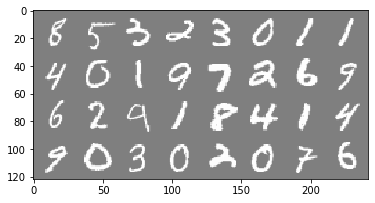

    8     5     3     2


In [36]:
batch_size = 32
lr = 0.0002
train_epoch = 40
trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images)

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### The adverserial Networks:



#### The Generative Network:

Input: x values sampled from uniform distribution

Output: 32 x 32 Image, that should look like the data from MNist 

In [37]:
# The Generative Network

class generativeNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 10, out_features=6 * 6)
        
        self.fc2 = nn.Linear(in_features= 6 * 6, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=24 * 24)
        
        self.fc4 = nn.Linear(in_features= 24 * 24, out_features=28 * 28)
        
        self.ReLU = nn.LeakyReLU()
 
    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return x

#### The discriminative network:

Input: Takes 32 x 32 Image as Input
Output: probability of it being real data (non generated)

In [55]:
class discrimNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 28 * 28, out_features=22 * 22)
        
        self.fc2 = nn.Linear(in_features= 22 * 22, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=6 * 6)
        
        # 2 class fake and real data
        self.fc4 = nn.Linear(in_features= 6 * 6, out_features=2)
        
        #self.drop = nn.Dropout(p=0.5)
        self.ReLU = nn.LeakyReLU()
        
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        
        x = x.view(x.shape[0], 28 * 28)
    
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return self.soft(x)

### Simple helper functions


In [56]:
# function for sampling the noise data

def sample_noise(batch_size=batch_size):
    noise_batch = []
    for i in range(batch_size):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, 10)
        #s = np.random.uniform(0,1, 10) # 10 values sample from uniform distribution
        noise_batch.append(s)

    noise_batch = torch.from_numpy(np.asarray(noise_batch)).float() 
    return noise_batch

In [64]:
# function to plot the losses

def plot_losses(loss_g, loss_d, k):
    xg = [i for i in range(len(loss_g))]
    xd = [i for i in range(len(loss_d))]
    
    d = []
    sum = 0
    for i in range(len(loss_d)):
        sum += loss_d[i]
        if i % k == k-1:
            d.append(sum / k)
            
    plt.plot( loss_g, label='g')
    plt.plot( d, label='d')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.title("Loss of D ang G")

    plt.legend()

    plt.show()

### Train the Networks:

In [58]:
torch.cuda.get_device_capability(device=None)
torch.cuda.get_device_name(device=None)

'GeForce GTX 1050'

In [59]:
# calculate the real labels
a_real = []
a_fake = []
for i in range(batch_size):
    sub1 = [1]
    sub2 = [0]
    for j in range(1):
        sub1.append(0)
        sub2.append(1)
    a_real.append(sub1)
    a_fake.append(sub2)

labels_real = torch.tensor(a_real, dtype=torch.float).cuda()
labels_fake = torch.tensor(a_fake, dtype=torch.float).cuda()

In [60]:
G = generativeNet()
D = discrimNet()
G.to(device)
D.to(device)

# Define a Loss function and optimizer
optimizer1 = optim.Adam(D.parameters(), lr=lr)
optimizer2 = optim.Adam(G.parameters(), lr=lr)
# k = discriminator interations
k = 3

criterion = nn.BCELoss()

loss_g = []
loss_d = []
imag = []

# Train the network
for epoch in range(train_epoch):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            # sample batch_size * 10 matrix of uniform distributed noise
            noise = sample_noise(batch_size).to(device)
            outputs_fake = D(G(noise).detach())
            outputs_real = D(inputs)
            #train d on real images
            loss = criterion(outputs_real, labels_real)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            #train d on fake images
            loss = criterion(outputs_fake, labels_fake)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] D loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_d.append(running_loss)
                running_loss = 0.0

    # 1 training step for G
    #print("\t\t Running %dth iteration on G" % epoch)
    running_loss = 0.0
    for i in range(200):
        optimizer2.zero_grad()
        noise = sample_noise(batch_size).to(device)
        loss = criterion(D(G(noise)), labels_real)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] G loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_g.append(running_loss)
                running_loss = 0.0
    s = sample_noise(1).cuda()
    a = G(s)
    a = torch.reshape(G(s), (1, 28,28)).cpu()
    npimg = a.detach().numpy()
    imag.append(npimg)

print('Finished Training')

Currently running epoch Nbr 0
	[1,   100] D loss: 0.295898714
	[1,   200] D loss: 0.001183240
	[2,   100] D loss: 0.000203470
	[2,   200] D loss: 0.000105990
	[3,   100] D loss: 0.000049962
	[3,   200] D loss: 0.000031984
	[3,   100] G loss: 0.673376070
	[3,   200] G loss: 0.001504176
Currently running epoch Nbr 1
	[1,   100] D loss: 0.304571390
	[1,   200] D loss: 0.000161083
	[2,   100] D loss: 0.000048055
	[2,   200] D loss: 0.000026936
	[3,   100] D loss: 0.000016331
	[3,   200] D loss: 0.000011759
	[3,   100] G loss: 0.763416630
	[3,   200] G loss: 0.000415069
Currently running epoch Nbr 2
	[1,   100] D loss: 0.229139726
	[1,   200] D loss: 0.000162325
	[2,   100] D loss: 0.000044206
	[2,   200] D loss: 0.000025966
	[3,   100] D loss: 0.000017840
	[3,   200] D loss: 0.000016747
	[3,   100] G loss: 0.564954048
	[3,   200] G loss: 0.000617942
Currently running epoch Nbr 3
	[1,   100] D loss: 0.260068206
	[1,   200] D loss: 0.000378580
	[2,   100] D loss: 0.000076163
	[2,   200] D lo

	[3,   200] D loss: 0.000618810
	[3,   100] G loss: 0.682527054
	[3,   200] G loss: 0.001558208
Currently running epoch Nbr 29
	[1,   100] D loss: 0.217853451
	[1,   200] D loss: 0.002507132
	[2,   100] D loss: 0.000647999
	[2,   200] D loss: 0.000739750
	[3,   100] D loss: 0.000257520
	[3,   200] D loss: 0.000195174
	[3,   100] G loss: 0.906651694
	[3,   200] G loss: 0.000274543
Currently running epoch Nbr 30
	[1,   100] D loss: 0.268860820
	[1,   200] D loss: 0.006232832
	[2,   100] D loss: 0.001400657
	[2,   200] D loss: 0.001101914
	[3,   100] D loss: 0.000603182
	[3,   200] D loss: 0.000395323
	[3,   100] G loss: 0.878004009
	[3,   200] G loss: 0.000891206
Currently running epoch Nbr 31
	[1,   100] D loss: 0.207165110
	[1,   200] D loss: 0.002037590
	[2,   100] D loss: 0.000980612
	[2,   200] D loss: 0.000754461
	[3,   100] D loss: 0.000399696
	[3,   200] D loss: 0.000274549
	[3,   100] G loss: 0.964269902
	[3,   200] G loss: 0.000294304
Currently running epoch Nbr 32
	[1,   100] 

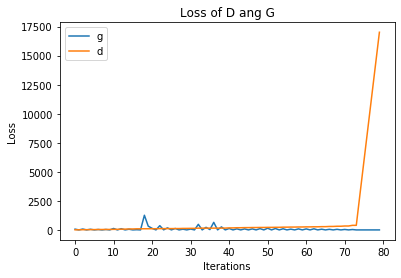

In [66]:
plot_losses(loss_g, loss_d, k)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


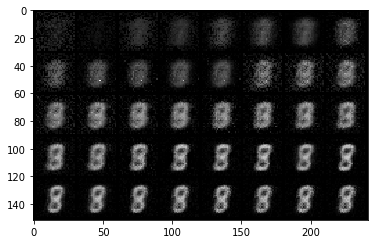

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [67]:
mpl.rc('image', cmap='RdBu')
imags = torch.tensor(imag)
torchvision.utils.save_image(imags, "gan_adam.png")
img = torchvision.utils.make_grid(imags)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='RdBu')
plt.show()

print(D(G(s).detach()))